In [1]:
#IMPORTAR LIBRERIAS NECESARIAS

import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from keras.utils import Sequence

In [2]:
#VERIFCAMOS SI EL GPU ESTA FUNCIONANDO CORRECTAMENTE
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

2.10.1
Num GPUs Available:  1


'/device:GPU:0'

In [3]:
#CARGA DE LA UBICACION DE LOS DATOS

fracture_locations ={}
#CARGAR TABLA DE ETIQUETAS
with open(os.path.join('TRAIN_LABEL.csv'), mode='r') as infile:  
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
        file_name = rows[0]
        locations = rows[1:5]
        fracture = rows[5]
        # SI SE ENCUENTRA FRACTURA AÑADIR AL DICCIONARIO EL NOMBRE Y LAS COORDENADAS DEL BOUNDING BOX
        if fracture == '1':
            locations = [int(i) for i in locations]
            if file_name in fracture_locations:
                fracture_locations[file_name].append(locations)
            else:
                fracture_locations[file_name] = [locations]
   

In [13]:
#CARGA Y MEZCLA DE DATOS 

folder = 'train_images'
file_names = os.listdir(folder)
random.shuffle(file_names)
#DIVIDIR EN DATOS DE ENTRENAMIENTO Y VALIDACION
n_valid_samples = 125
train_filenames = file_names[n_valid_samples:]
valid_filenames = file_names[:n_valid_samples]
print('NUMERO DE DATOS DE ENTRENAMIENTO', len(train_filenames))
print('NUMERO DATOS DE VALIDACION', len(valid_filenames))
n_train_samples = len(file_names) - n_valid_samples

NUMERO DE DATOS DE ENTRENAMIENTO 1029
NUMERO DATOS DE VALIDACION 125


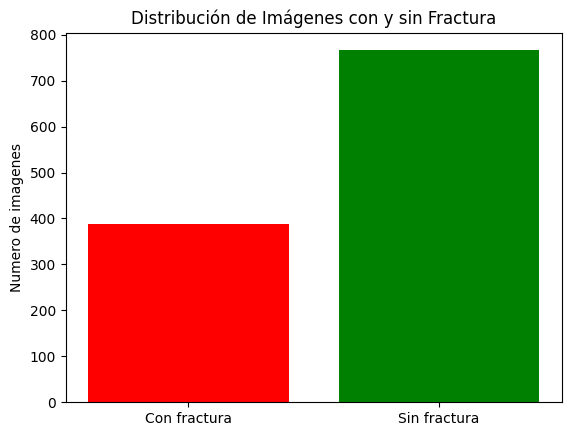

In [14]:
#EXPLORACION DE DATOS

#NUMERO DE IMAGENES CON O SIN FRACTURAS
fracture_counts = {'Con fractura': 0, 'Sin fractura': 0}
for i in file_names:
    if "no" in i:
        fracture_counts['Sin fractura'] += 1
    else:
        fracture_counts['Con fractura'] += 1
plt.bar(fracture_counts.keys(), fracture_counts.values(), color=['red', 'green'])
plt.title('Distribución de Imágenes con y sin Fractura')
plt.ylabel('Numero de imagenes')
plt.show()

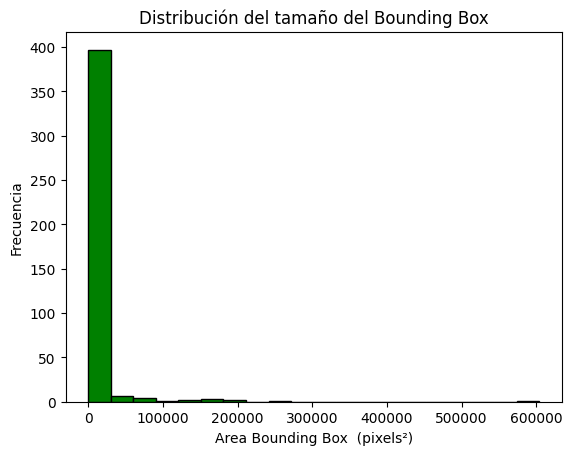

In [15]:
#CALCULO DEL AREA DE CADA BOUNDING BOX (ANCHO * ALTO) 
bounding_box_areas = [loc[3] * loc[2] for locations in fracture_locations.values() for loc in locations]
# GRAFICAR
plt.hist(bounding_box_areas, bins=20, color='green', edgecolor='black')
plt.title('Distribución del tamaño del Bounding Box')
plt.xlabel('Area Bounding Box  (pixels²)')
plt.ylabel('Frecuencia')
plt.show()

In [16]:
#GENERADOR DE DATOS
#TOMA ALGUNOS NOMBRES DE ARCHIVOS, TAMAÑO DE LOTE Y OTROS PARÁMETROS.
#GENERA UN LOTE ALEATORIO DE IMÁGENES Y MÁSCARAS.
#PERMITIR LA CARGA DE IMÁGENES TRUNCADAS

from PIL import Image, ImageFile
import numpy as np
import os
import random
from skimage.transform import resize
from keras.utils import Sequence


ImageFile.LOAD_TRUNCATED_IMAGES = True


class generator(Sequence):
    
    def __init__(self, folder, filenames, fracture_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.fracture_locations = fracture_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    #CONVERITR LA IMAGEN EN UN ARRAY ESCALADO Y REDIMENSIONADO. LO MISMO PARA LA MÁSCARA PARA CREAR UN MAPA BINARIO DE LAS FRACTURAS.
    #ESTA FUNCION PERMITE QUE TANTO LA IMAGEN COMO LA MÁSCARA TENGAN LA MISMA FORMA ((256, 256, 1)).
    def __load__(self, filename):
        try:
            
            img = Image.open(os.path.join(self.folder, filename))
            img = img.convert('L') 
            img = np.array(img)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            return None, None
        
        msk = np.zeros(img.shape)

        n
        filename = filename.split('.')[0]
        
        if self.fracture_locations and filename in self.fracture_locations:
            
            for location in self.fracture_locations[filename]:
                
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1        
        
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
                
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk



    #PROCESAR UNA IMAGEN PARA HACER PREDICCIONES, PERO EN ESTE CASO NO GENERA UNA MÁSCARA, YA QUE ESTÁ ORIENTADA A ESCENARIOS DE PREDICCIÓN
    def __loadpredict__(self, filename):
        try:
            img = Image.open(os.path.join(self.folder, filename))
            img = img.convert('L')  # Convert to grayscale if needed
            img = np.array(img)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
            return None
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        img = np.expand_dims(img, -1)
        return img
        

    #SELECCIONAR UN LOTE DE ARCHIVOS EN FUNCIÓN DEL ÍNDICE.
    def __getitem__(self, index):
        
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        if self.predict:        
            imgs = [self.__loadpredict__(filename) for filename in filenames]    
            imgs = [img for img in imgs if img is not None]
            imgs = np.array(imgs)
            return imgs, filenames
        else:        
            items = [self.__load__(filename) for filename in filenames]
            items = [item for item in items if item[0] is not None and item[1] is not None]
            imgs, msks = zip(*items)
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:         
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            return int(len(self.filenames) / self.batch_size)


In [17]:
#RED
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)    
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)   
    return keras.layers.add([x, inputs])


def create_network(input_size, channels, n_blocks=3, depth=4):
    # ENTRADA
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    #BLOQUES RESIDUALES
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # SALIDA
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [3]:
#FUNCIÓN DE PÉRDIDA DE IOU
def iou_loss(y_true, y_pred):
    y_true = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

#COMBINAR BCE LOSS Y IOU LOSS
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

#IOU COMO METRICA
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [19]:
#CREACION DE LA RED Y COMPILADOR
model = create_network(input_size=256, channels=32, n_blocks=3, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [20]:
#CREACION DE GENERADOR DE DATOS DE ENTRENAMIENTO Y VALIDACION
folder = 'TRAIN_IMAGES'
train_gen = generator(folder, train_filenames, fracture_locations, batch_size=16, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, fracture_locations, batch_size=16, image_size=256, shuffle=False, predict=False)

In [9]:
#ENTRENAMIENTO DEL MODELO
history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=20)
#GUARDAR EL MODELO
model.save('fracture_model_2.h5')
import json

#CONVERTIR EL HISTORIAL DE ENTRENAMIENTO A UN TIPO SERIALIZABLE EN JSON
historial_serializable = {key: [float(val) for val in values] for key, values in history.history.items()}

#GUARDAR EL HISTORIAL DE ENTRENAMIENTO EN UN ARCHIVO JSON
with open('training_history_2.json', 'w') as file:
    json.dump(historial_serializable, file)

Epoch 1/20
66/66 [==============================] - 170s 2s/step - loss: 0.5372 - accuracy: 0.9769 - mean_iou: 0.6343 - val_loss: 0.5206 - val_accuracy: 0.9927 - val_mean_iou: 0.6128 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 157s 2s/step - loss: 0.5093 - accuracy: 0.9950 - mean_iou: 0.6722 - val_loss: 0.5103 - val_accuracy: 0.9898 - val_mean_iou: 0.5185 - lr: 9.9384e-04
Epoch 3/20
66/66 [==============================] - 161s 2s/step - loss: 0.5057 - accuracy: 0.9934 - mean_iou: 0.6106 - val_loss: 0.5021 - val_accuracy: 0.9901 - val_mean_iou: 0.5286 - lr: 9.7553e-04
Epoch 4/20
66/66 [==============================] - 156s 2s/step - loss: 0.5036 - accuracy: 0.9920 - mean_iou: 0.5989 - val_loss: 0.5059 - val_accuracy: 0.9927 - val_mean_iou: 0.6128 - lr: 9.4550e-04
Epoch 5/20
66/66 [==============================] - 153s 2s/step - loss: 0.5049 - accuracy: 0.9926 - mean_iou: 0.6138 - val_loss: 0.5247 - val_accuracy: 0.9926 - val_mean_iou: 0.6121 - lr: 9.0451e-04
Epoc

In [22]:
from tensorflow.keras.models import load_model 
import json
# Cargar el modelo
model = load_model('fracture_model_2.h5', custom_objects={'iou_bce_loss': iou_bce_loss, 'mean_iou': mean_iou})

# Cargar el historial de entrenamiento
with open('training_history_2.json', 'r') as file:
    historial_cargado = json.load(file)
 

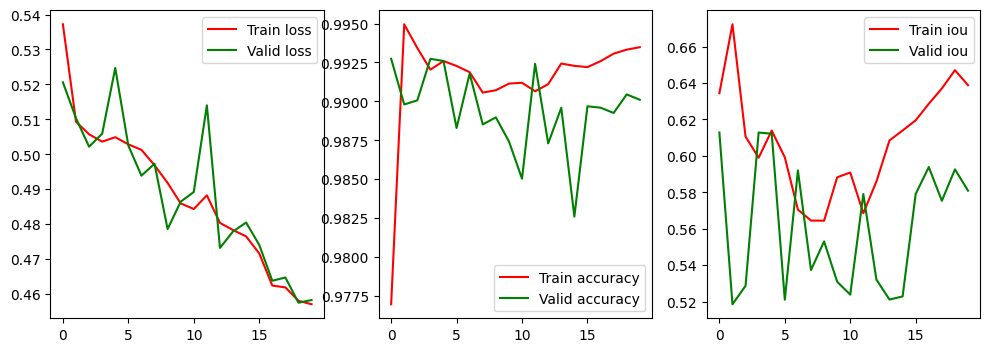

In [24]:
#GRAFICA RESULTADOS DEL ENTRENAMIENTO
from matplotlib import pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(historial_cargado["loss"], label="Train loss",color='red')
plt.plot(historial_cargado["val_loss"], label="Valid loss",color='green')
plt.legend()
plt.subplot(132)
plt.plot( historial_cargado["accuracy"], label="Train accuracy",color='red')
plt.plot( historial_cargado["val_accuracy"], label="Valid accuracy",color='green')
plt.legend()
plt.subplot(133)
plt.plot( historial_cargado["mean_iou"], label="Train iou",color='red')
plt.plot(historial_cargado["val_mean_iou"], label="Valid iou",color='green')
plt.legend()
plt.show()

### Evaluacion

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf


In [4]:
model = load_model('fracture_model_2.h5', custom_objects={'iou_bce_loss': iou_bce_loss, 'mean_iou': mean_iou})

In [5]:
df = pd.read_csv('test_labels.csv')
df.columns = ['image_name', 'x', 'y', 'width', 'height', 'target']
df.head()

,image_name,x,y,width,height,target
0,fracture (1).jpg,100.0,62.0,52.0,49.0,1
1,fracture (2).jpg,103.0,95.0,36.0,35.0,1
2,fracture (3).jpg,104.0,86.0,36.0,35.0,1
3,fracture (4).png,84.0,372.0,59.0,79.0,1
4,fracture (4).png,596.0,268.0,119.0,116.0,1


In [6]:
annotations = {}
for _, row in df.iterrows():
    image_base = os.path.splitext(row['image_name'])[0]
    if int(row['target']) == 1:
        bbox = [int(row['x']), int(row['y']), int(row['width']), int(row['height'])]
        annotations.setdefault(image_base, []).append(bbox)

In [7]:
# Función para crear la máscara de ground truth a partir de las anotaciones
def create_ground_truth_mask(image, image_base, ann_dict):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    if image_base in ann_dict:
        for (x, y, w, h) in ann_dict[image_base]:
            mask[y:y+h, x:x+w] = 1
    return mask

In [8]:
def compute_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return 1.0 if union == 0 else intersection / union

In [9]:
# Crear un diccionario de ground truth:
# Si target==1 se consideran positivos (con fractura) y se guardan las anotaciones,
# si target==0 se consideran negativos.
ground_truth = {}
for _, row in df.iterrows():
    image_name = row['image_name']
    target = int(row['target'])
    if image_name not in ground_truth:
        ground_truth[image_name] = {'target': target, 'bboxes': []}
    if target == 1:
        bbox = [row['x'], row['y'], row['width'], row['height']]
        ground_truth[image_name]['bboxes'].append(bbox)

In [10]:
confidence_threshold = 0.5
input_size = model.input_shape[1]

# Carpeta con imágenes de prueba
test_images_folder = 'TEST_IMAGES'
test_files = os.listdir(test_images_folder)

ious = []

true_positive = 0
false_negative = 0
true_negative = 0
false_positive = 0

In [12]:
for file in test_files:
    image_path = os.path.join(test_images_folder, file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image_resized = cv2.resize(image, (input_size, input_size))
    image_base = os.path.splitext(file)[0]
    true_mask = create_ground_truth_mask(image_resized, image_base, annotations)
    img_norm = image_resized.astype(np.float32) / 255.0
    img_norm = np.expand_dims(img_norm, axis=-1)  
    img_input = np.expand_dims(img_norm, axis=0)     

    pred_mask = model.predict(img_input)[0, ..., 0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
    max_confidence = np.max(pred_mask)
    
    # Obtener la etiqueta real (positiva o negativa)
    if file in ground_truth:
        gt_positive = (ground_truth[file]['target'] == 1)
    else:
        gt_positive = False


    detected = max_confidence > confidence_threshold

    if gt_positive:
        if detected:
            true_positive += 1
        else:
            false_negative += 1
    else:
        if detected:
            false_positive += 1
        else:
            true_negative += 1

    iou = compute_iou(pred_mask_bin, true_mask)
    ious.append(iou)


if (true_negative + false_positive) > 0:
    specificity = true_negative / (true_negative + false_positive)
else:
    specificity = 0

if (true_positive + false_positive) > 0:
    precision = true_positive / (true_positive + false_positive)
else:
    precision = 0

if (true_positive + false_negative) > 0:
    recall = true_positive / (true_positive + false_negative)
else:
    recall = 0

print(f"Sensitivity (Recall): {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"Mean IoU: {np.mean(ious):.3f}")

1/1 [==============================] - 0s 58ms/step
Sensitivity (Recall): 0.578
Precision: 0.722
Specificity: 0.811
Mean IoU: 0.497


Evaluación:

Sensibilidad (Recall): Proporción de imágenes positivas correctamente detectadas.  Esto significa que, de todas las imágenes que realmente tienen fractura, el modelo identifica correctamente el 57.8%. Es decir, el 42.2% de las fracturas se pierden (falsos negativos).

Precisión: Proporción de imágenes etiquetadas como positivas por el modelo que realmente son positivas.Indica que, de todas las imágenes que el modelo clasifica como fracturadas, el 72.2% efectivamente tienen fractura. Esto sugiere que el 27.8% de las predicciones positivas son incorrectas (falsos positivos).

Especificidad: Proporción de imágenes negativas correctamente clasificadas como negativas.Significa que, de todas las imágenes que no tienen fractura, el modelo clasifica correctamente el 81.1% como negativas. Esto implica que el 18.9% se clasifica erróneamente como positivas.

IoU: Area en la que el cuadro predicho se superpone con el cuadro real es equivalente al 49% del área combinada de ambos. En términos simples, casi la mitad del área total (del predicho y del real) coincide.

